### Imports 

In [196]:
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import  CSVLogger
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Load datasets

In [197]:
train_x = np.load("./data/train/training_data_x.npy")
train_y = np.load("./data/train/training_data_y.npy")

In [198]:
val_x = np.load("./data/val/validating_data_x.npy")
val_y = np.load("./data/val/validating_data_y.npy")

### Data pre-processing

Normalizing the data into the range 0,1


In [199]:
train_x = train_x / 255.0
train_y /= 96.0

In [200]:
val_x = val_x / 255.0
val_y /= 96.0

### Create model

#### Hyper-parameters

In [220]:
checkpoints_dir = './checkpoints/'


input_shape = (96, 96, 1)  

num_keypoints = 15   
batch_size = 32
epochs = 350 
output_units = num_keypoints * 2

learning_rate =0.0001


datagen = ImageDataGenerator(
    rotation_range=10,       # Rotate the image randomly by 10 degrees
    width_shift_range=0.1,   # Shift the image horizontally by 10%
    height_shift_range=0.1,  # Shift the image vertically by 10%
    shear_range=0.1,         # Shear the image randomly
    zoom_range=0.1,          # Zoom in or out by 10%
    horizontal_flip=True,    # Randomly flip the image horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    fill_mode='nearest'      # Fill missing pixels with the nearest pixels
)

val_datagen = ImageDataGenerator()


#### Model architecture

In [221]:
 
def build_CNN_model(): 

        model = Sequential()
        # The first two layers with 32 filters of window size 3x3
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(output_units, activation='relu'))

        return model

### Train the model

#### Custom checkpoint

In [227]:
class CustomModelCheckpoint(Callback):
    def __init__(self, save_freq, checkpoint_dir, checkpoint):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint = checkpoint

    def on_epoch_end(self, epoch, logs = None):
        if (epoch + 1) % self.save_freq == 0:
            file_path = os.path.join(self.checkpoint_dir, f'CNN_{self.checkpoint + epoch + 1}.weights.h5')
            self.model.save_weights(file_path)
            print(f'\nModel saved to {file_path}')

In [228]:
checkpoint = 0

custom_checkpoint_callback = CustomModelCheckpoint(save_freq=10, checkpoint_dir=checkpoints_dir, checkpoint=checkpoint)
 
csv_logger = CSVLogger('training_log.csv', append=True)

#### Check if GPU is available 

In [229]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    print("Using GPU for training.")
else:
    print("No GPUs available. Using CPU for training.")

No GPUs available. Using CPU for training.


In [230]:
 
model = build_CNN_model()
optimizer = Adam(learning_rate=learning_rate   )
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'accuracy'])

history = model.fit(datagen.flow(train_x, train_y, batch_size=batch_size), verbose=1,  epochs=epochs,
                   validation_data=  (val_x, val_y)  ,callbacks=[custom_checkpoint_callback , csv_logger] )
model.evaluate(val_x, val_y)

Epoch 1/350
177/177 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.2412 - loss: 0.1106 - mae: 0.2546 - val_accuracy: 0.3887 - val_loss: 0.0286 - val_mae: 0.1520
Epoch 2/350
177/177 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.2243 - loss: 0.0141 - mae: 0.0942 - val_accuracy: 0.1099 - val_loss: 0.1962 - val_mae: 0.4114
Epoch 3/350
177/177 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.2420 - loss: 0.0102 - mae: 0.0802 - val_accuracy: 0.3716 - val_loss: 0.1847 - val_mae: 0.3984
Epoch 4/350
177/177 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.2564 - loss: 0.0081 - mae: 0.0712 - val_accuracy: 0.3730 - val_loss: 0.1798 - val_mae: 0.3929
Epoch 5/350
177/177 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.2776 - loss: 0.0071 - mae: 0.0660 - val_accuracy: 0.3787 - val_loss: 0.1870 - val_mae: 0.4005
Epoch 6/350
177/177 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.3084 - loss: 0.0063 - mae: 0.0621 - val_accuracy: 0.3830 - val_loss: 0.1549 - val_mae: 0.3642
Epoch 7/350
177/

[0.001015960588119924, 0.018743468448519707, 0.6085106134414673]

In [231]:
def draw_keypoints(image, predicted_keypoints, type ='Predicted'): 
    
    keypoint_labels = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']
    
    predicted_keypoints = pd.Series(predicted_keypoints,index=keypoint_labels)
    keypoints = {}
     
    # Extract keypoint pairs from the series
    for key in predicted_keypoints.index:
        if key.endswith('_x'):
            # Base name without the coordinate suffix
            base_name = key[:-2]
            x_value = predicted_keypoints[key]
            y_value = predicted_keypoints[base_name + '_y']
            keypoints[base_name] = (x_value, y_value)

    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Plot each keypoint
    for key, (x, y) in keypoints.items():
        plt.plot(x, y, 'ro')  # Red dots for keypoints
        plt.text(x, y, key, fontsize=6, color='lime')

    plt.title(f'{type} Facial Keypoints Detection')
    plt.show()

In [346]:
input_image = np.expand_dims(val_x[150], axis=-1)  

 
input_image = np.expand_dims(input_image, axis=0)   

# Make prediction
predicted_keypoints = model.predict(input_image)

 
predicted_keypoints = predicted_keypoints[0]  * 96
 
print("Predicted Keypoints:", predicted_keypoints)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Keypoints: [65.43756  37.929165 29.765253 38.420986 58.90575  36.662533 73.48605
 35.325737 37.38853  39.28533  22.090525 40.042065 53.414    30.131878
 80.195    28.627232 39.054707 32.7716   14.954684 35.115475 47.51757
 63.90509  69.87585  72.39609  34.02337  76.96256  50.63698  75.06541
 47.9283   78.10058 ]


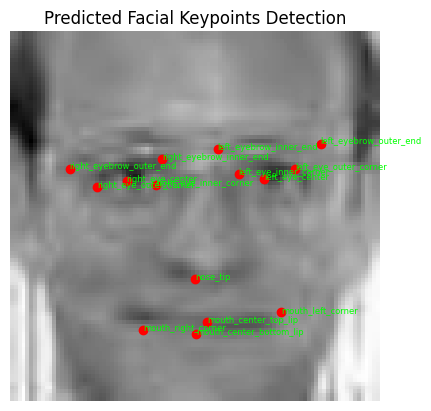

In [347]:
draw_keypoints(val_x[150],predicted_keypoints,"Predicted")

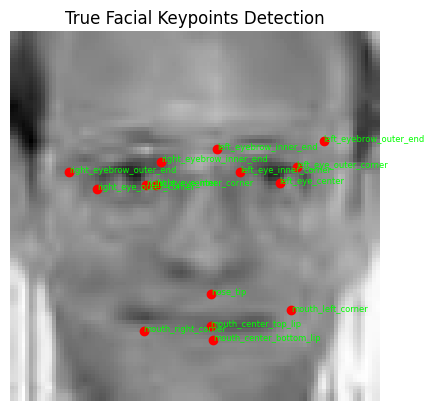

In [348]:
draw_keypoints(val_x[150],val_y[150] * 96,"True")

In [251]:
lookid_data  = pd.read_csv("./data/IdLookupTable.csv")

In [308]:
test_data = pd.read_csv("./data/test/test.csv")

test_images = []
for i in range(0,1783):
    img = test_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    
    test_images.append(img)
 
test_images = np.array(test_images,dtype = 'float')
test_images /= 255.0
X_test = test_images.reshape(-1,96,96,1) 

In [320]:
X_test.shape

(1783, 96, 96, 1)

### Predict Test data and create a sumbission file 

In [340]:
model.load_weights("./checkpoints/CNN_350.weights.h5")

In [331]:
tf.config.run_functions_eagerly(True)

In [332]:
pred = model.predict(X_test )


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step

c:\Users\vinew\anaconda3\envs\kaggle-tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step


In [333]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)
rowid = lookid_data['RowId']
rowid=list(rowid)

In [334]:
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

In [335]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [336]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('submission_CNN.csv',index = False)